# Demonstrate simple MESMER - CLIMADA coupling

### Imports

In [67]:
from climada.hazard import Hazard
from climada.util.api_client import Client
from climada.engine import ImpactCalc
from climada.engine.unsequa import InputVar
from climada.engine.unsequa import CalcImpact
from climada.entity import ImpactFunc, ImpactFuncSet

from pathlib import Path

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # Cartopy coordinate reference systems
import cartopy.feature as cfeature  # Cartopy features like borders

client = Client()

## Simple Example: Heavy Precipitation

In this example we want to look at the expected damages of heavy precipitation over a specific region, for example Germany. We take as hazard one emulation obtained from MESMER and we feed it into Climada to look at the related risks.

**DISCLAIMER!** The data provided is just dummy data, it's not fully tested yet, please don't look too much into the physical interpretation of the results. This is just a proof of concept.

### Hazard: MEMSER output

The output from MESMER is usually an xarray dataset containing a certain hazard indicator at a yearly time resolution (even though for some variables, monthly resolution is available as well).

The current spatial resolution used in MESMER is 2.5 degrees, which is the resolution chosen to regrid all the ESM output.
When developing a meaningful case study, some considerations are necessary to understand what makes sense at this hazard scale.

In this example we look at a heavy precipitation indicator: Annual Maximum Daily Precipitation, shorty called Rx1day.
As the name suggests, it is the maximum daily precipitation value that is experienced in one year, and is measured in mm(/day).

In [6]:
#Please set the directory properly to the location where you have the dummy data
current_directory = Path().resolve()
print(current_directory)

/home/lpierini/Climada-Mesmer


In [7]:
DATA = Path(current_directory)

If you want to have a look at the data format, we can load directly the xarray dataset

In [98]:
ds_haz_mm = xr.open_dataset(DATA/ 'emu_CanESM5_mmb20_linloc.nc');

This dataset contains 20 emulations or Rx1day obtained with MESMER (dimension 'member'), for 251 years, over land. These emulations are produced for a given ESM, but one could also look at multiple ESMs.

In this first example we take only one emulation:

In [99]:
ds_haz = ds_haz_mm.sel(member = 7)

Let's see how it looks over Germany for one specific year

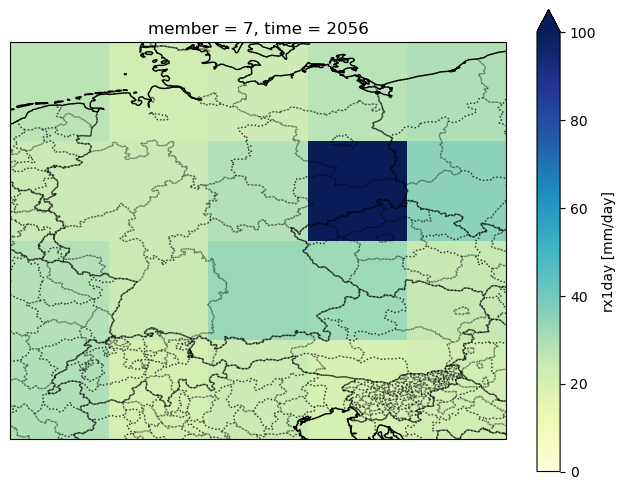

In [100]:
ds_germany = ds_haz.rx1day.sel(lat = slice(46.25, 53.75), lon = slice(6.25, 16.25))

# Set up the plot with a Cartopy projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ds_germany.sel(time = 2056).plot(ax = ax, cmap = 'YlGnBu', vmin =0, vmax = 100, label = 'Annual Maximum Daily Precipitation (mm)')

# Add country borders on top
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)

# Add coastlines and other features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.5)  # Adds state/province borders

Now we put the selected hazard dataset in Climada input format. In this case, we have yearly values, and we identify each values as an event.

In [101]:
haz = Hazard.from_xarray_raster(
        ds_haz,
        hazard_type='HP',
        intensity_unit='mm/day',
        intensity = 'rx1day',
        coordinate_vars = {'event': 'time', 'longitude':'lon', 'latitude':'lat'},
    )

2024-10-22 18:13:29,266 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings


Since the dataset goes from the year 1850 to 2100, we have 251 years in total. Climada automatically assigns a frequency of 1 to each event, but we can specify by hand that the frequency should be 1/251 for each of them.

In [102]:
haz.frequency = np.ones(haz.size) * 1/haz.size

### Exposure Import

For the exposure, we use LitPop to obtain the assets in a specific region, for example Germany. It can also be provided by other sources, depending on the applications of interest.

In [103]:
exp = client.get_litpop(country='DEU')

In [104]:
exp.gdf['impf_HP'] = 1

<GeoAxes: title={'center': "LitPop Exposure for ['DEU'] at 150 as, year: 2018, financial mode: pc,\nexp: (1, 1), admin1_calc: False"}>

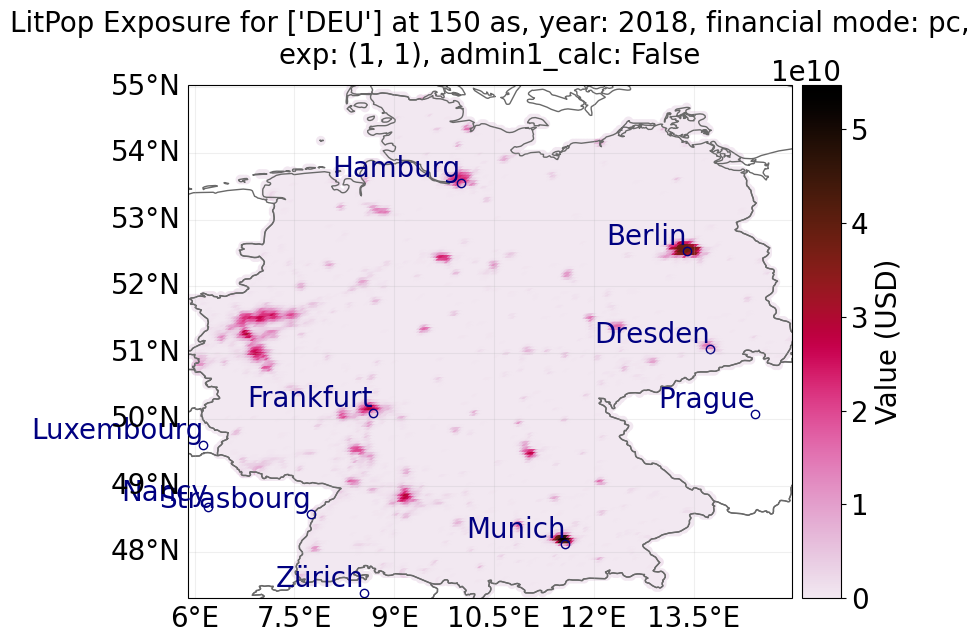

In [105]:
exp.plot_scatter()

### Define Impact Functions

Realistically, defining an impact function for heavy precipitation is not straightforward, as its impact are related mainly to floodings and it's not easy to understand when precipitation leads to floodings (except maybe in urban areas).

For our proof of concept, however, we take just a step function: after a certain intensity (e.g. 50 mm/day) threshold we have the maximum impact.

In [106]:
impfset = ImpactFuncSet([ImpactFunc.from_step_impf(haz_type='HP', intensity=(0, 50, 200), intensity_unit='mm/day')])

<Axes: title={'center': 'HP 1: '}, xlabel='Intensity (mm/day)', ylabel='Impact (%)'>

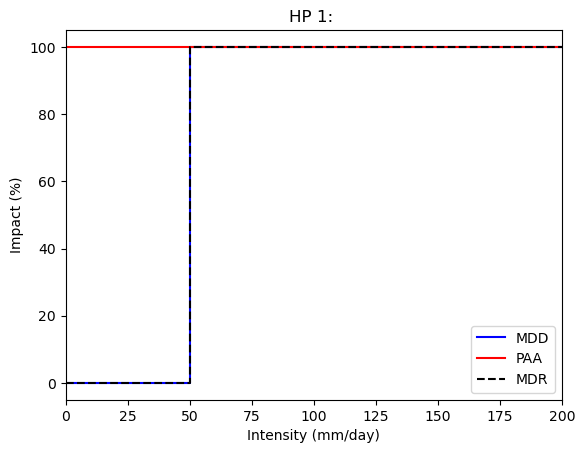

In [107]:
impfset.plot()

### Impact Computation

Now we can compute the impact from the selected hazard over the selected country

In [108]:
imp = ImpactCalc(exp, impfset, haz).impact() #impact on a single hazard realization

2024-10-22 18:13:59,992 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 15058 coordinates.


For example, let's look at the overall Expected annual impact

<GeoAxes: title={'center': 'Expected annual impact'}>

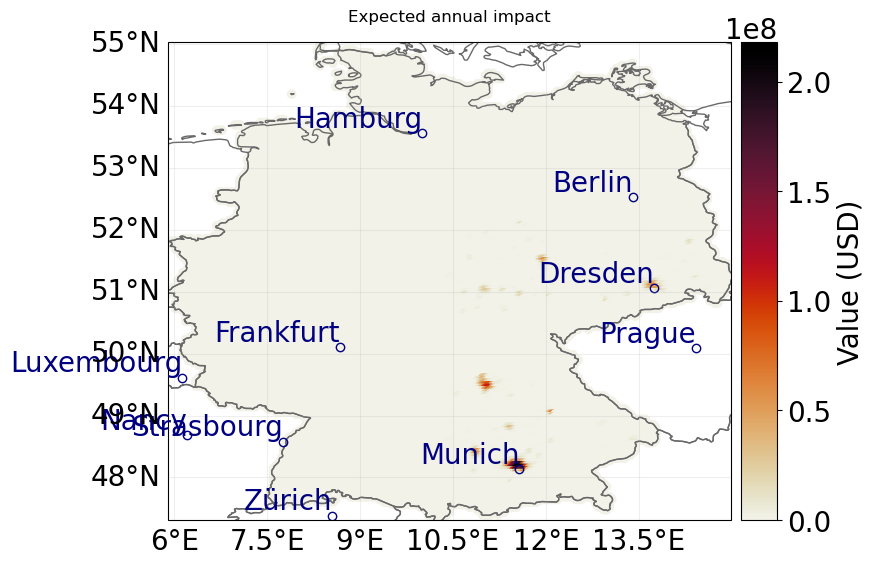

In [109]:
imp.plot_scatter_eai_exposure()

## Simple Example: Heavy Precipitation with Uncertainty and Sensitivity Analysis

In this example we build on the previous case, but we also look at the uncertainty and sensitivity following from introducing some level of variability in the hazard, exposure and vulnerability. For the hazard, we shall now consider **multiple emulations**, which represent some statistic variability.

### Hazard: MEMSER output

We keep looking at the heavy precipitation indicator: Annual Maximum Daily Precipitation (Rx1day).

In [110]:
#Please set the directory properly to the location where you have the dummy data
current_directory = Path().resolve()
print(current_directory)

/home/lpierini/Climada-Mesmer


In [111]:
DATA = Path(current_directory)

If you want to have a look at the data format, we can load directly the xarray dataset

In [112]:
ds_haz_mm = xr.open_dataset(DATA/ 'emu_CanESM5_mmb20_linloc.nc');

In [113]:
ds_haz_mm;

This dataset contains 20 emulations or Rx1day obtained with MESMER (dimension 'member'), for 251 years, over land.

In this second example we now take the **full ensemble**.

Now we put the selected hazard dataset in Climada input format. In this case, we have yearly values, and we identify each values as an event.

(Note: We will get some warnings because the time variable of the xarray dataset is just given by a number representing the year, it's not in the conventional date format.)

In [114]:
haz_ens = []
for ens in ds_haz_mm.member.values:
    haz_1m = Hazard.from_xarray_raster(
        ds_haz_mm.sel(member = ens),
        hazard_type='HP',
        intensity_unit='mm/day',
        intensity = 'rx1day',
        coordinate_vars = {'event': 'time', 'longitude':'lon', 'latitude':'lat'},
    )
    haz_1m.frequency = np.ones(haz_1m.size) * 1/haz_1m.size #set the frequency of each event to 1/251
    haz_ens.append(haz_1m)

2024-10-22 18:14:28,247 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-10-22 18:14:28,348 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-10-22 18:14:28,432 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-10-22 18:14:28,519 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-10-22 18:14:28,601 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-10-22 18:14:28,687 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-10-22 18:14:28,737 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-10-22 18:14:28,

In [115]:
len(haz_ens)
#haz_ens[0].frequency

20

In [116]:
haz_iv = InputVar.haz(haz_ens)

### Exposure Import

For the exposure, we use LitPop to obtain the assets in a specific region, for example Germany. It can also be provided by other sources, depending on the applications of interest.

In addition to what we have done in the previous example, we also add some variability in the exposure data.

In [117]:
exp = client.get_litpop(country='DEU')
exp.gdf['impf_HP'] = 1

In [118]:
#introduce some variability in the exposure
bounds_totval = [0.9, 1.1] #+- 10% noise on the total exposures value
bounds_noise = [0.9, 1.2] #-10% - +20% noise each exposures point
exp_iv = InputVar.exp([exp], bounds_totval, bounds_noise)

In [119]:
#exp.plot_scatter()

### Define Impact Functions

Starting from the step function used in the previous example, we add some uncertainty to the threshold intensity

In [120]:
impfset = ImpactFuncSet([ImpactFunc.from_step_impf(haz_type='HP', intensity=(0, 50, 200), intensity_unit='mm/day')])

In [121]:
#introduce some variability in the impact functions
bounds_impfi = [-10, 10] #-10 mm/day ; +10mm/day uncertainty on the intensity
bounds_mdd = None #No uncertainty in the mdd
bounds_paa = None #No uncertainty in the paa

impf_iv = InputVar.impfset(impf_set_list=[impfset],
                           bounds_impfi=bounds_impfi,
                           bounds_mdd=bounds_mdd,
                           bounds_paa=bounds_paa,
                           haz_id_dict={'HP': [1]})

In [80]:
#impfset.plot()

### Impact Computation

Now we can compute the impact from the selected hazard over the selected region, taking into account the variability on each input: hazard (given by multiple ensemble members), exposure, impact function.

In [122]:
#Impact calculation taking into account the variability on hazard, exposure, impact function
calc_imp = CalcImpact(exp_iv, impf_iv, haz_iv)

In [123]:
#sampling
output_imp = calc_imp.make_sample(N=2**7, sampling_kwargs={'skip_values': 2**8})
output_imp.get_samples_df().tail()

,ET,EN,IFi,HL
1275,0.902734,1.300234e+09,-2.226562,5.0
1276,1.048047,3.581936e+09,-2.226562,5.0
1277,1.048047,1.300234e+09,-7.226562,5.0
1278,1.048047,1.300234e+09,-2.226562,18.0
1279,1.048047,1.300234e+09,-2.226562,5.0


We can look for example at the impact distribution for different return periods.

In [124]:
#computing uncertainty for different return periods: 50, 100, 250 years
output_imp = calc_imp.uncertainty(output_imp, rp = [50, 100, 250])

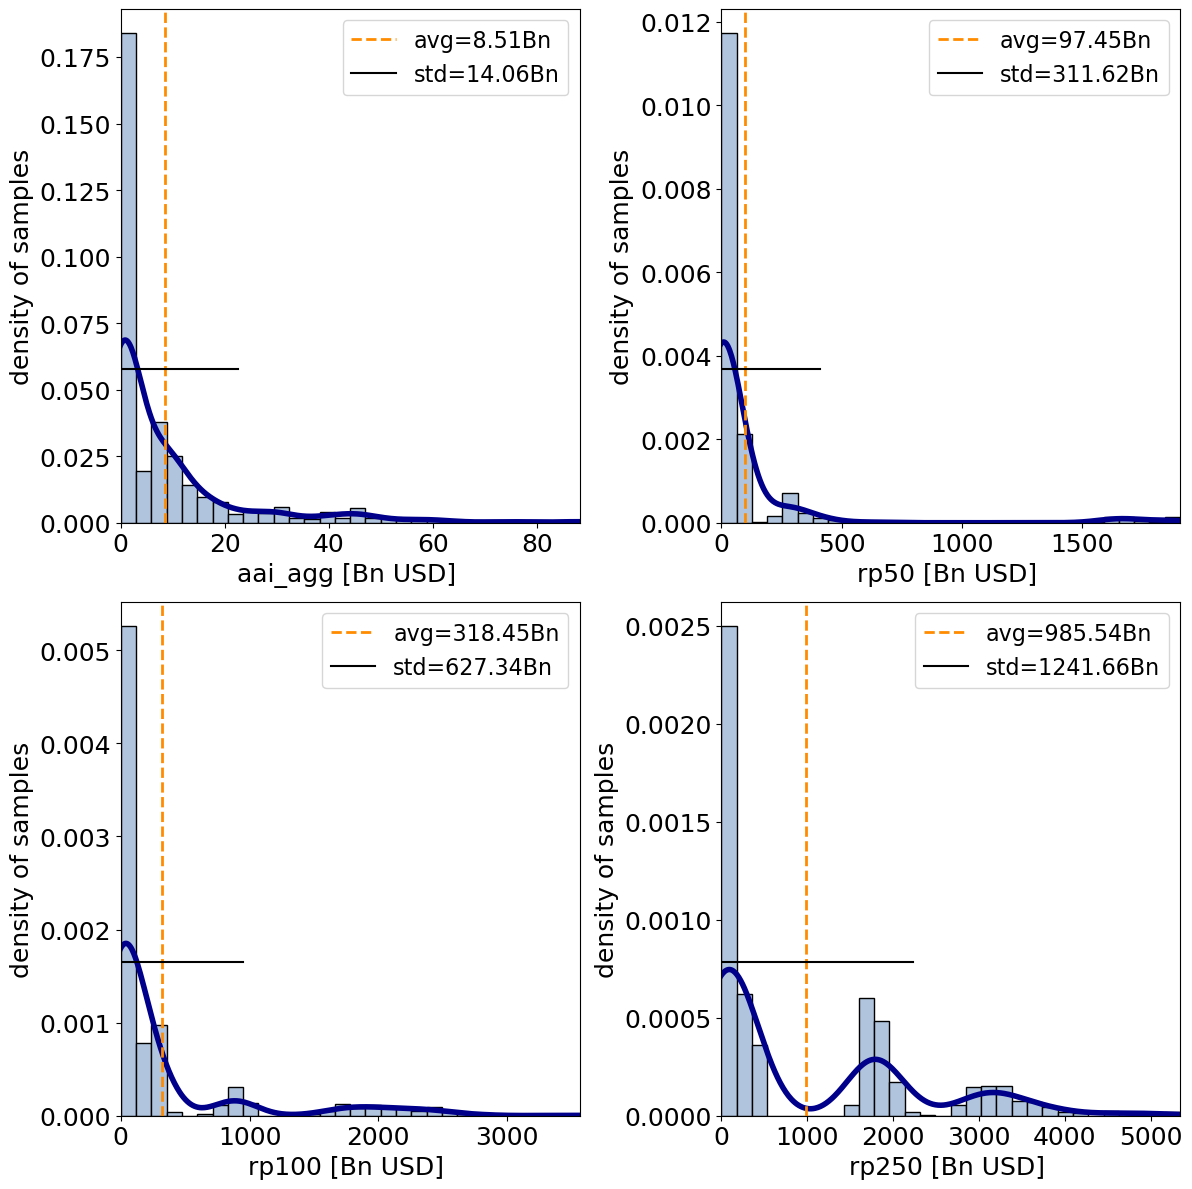

In [125]:
output_imp.plot_uncertainty(figsize=(12,12));

Then we can perform a sensitivy analysis to understand what source of variability is the main contributor to the overall uncertainty.

In [126]:
#Sensitivity analysis
output_imp = calc_imp.sensitivity(output_imp)

/home/lpierini/.conda/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/home/lpierini/.conda/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/home/lpierini/.conda/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/home/lpierini/.conda/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floatin

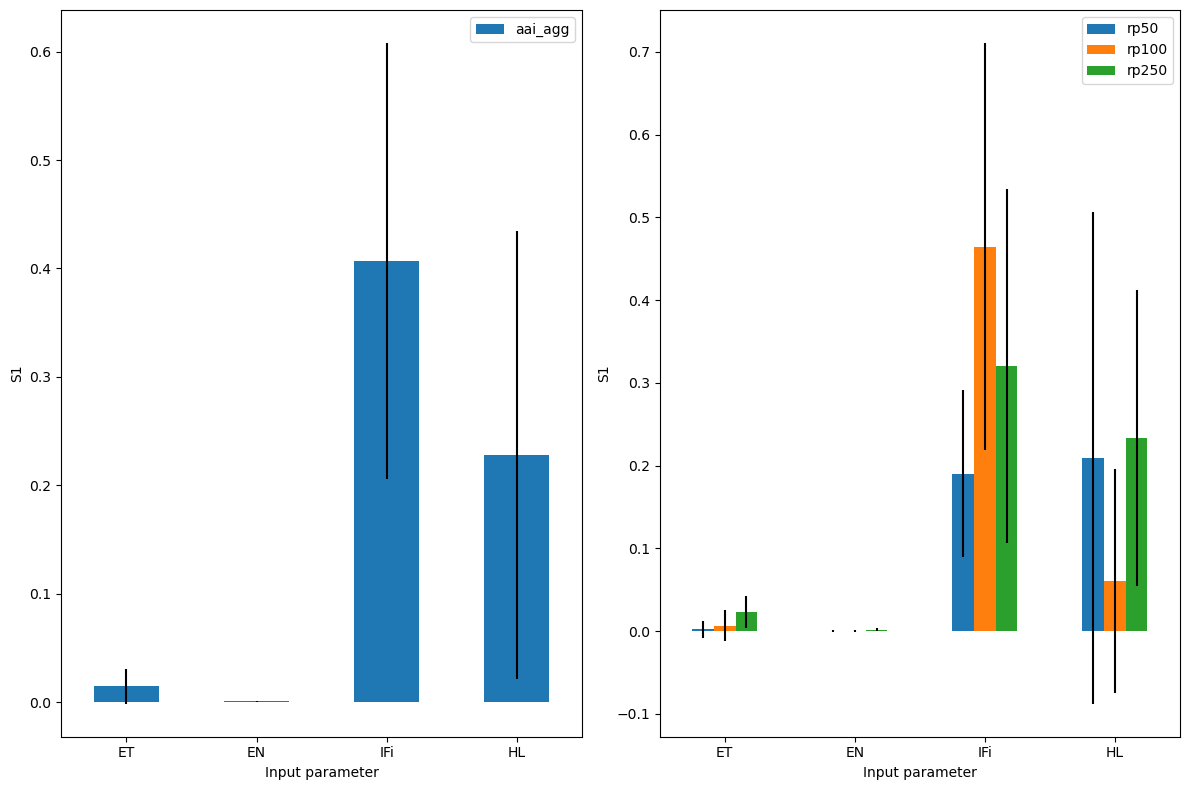

In [127]:
output_imp.plot_sensitivity(figsize=(12,8));

In this simple example IFi (variability in the impact function) seems to be the main source of uncertainty.

In [128]:
#One uncertainty dataframe
output_imp.get_unc_df('aai_agg').tail()

,aai_agg
1275,4.545163e+08
1276,5.271897e+08
1277,5.616248e+09
1278,9.938887e+09
1279,5.276795e+08


## Exercises

If you want to try something else, you could look at these prompts.

1. So fare we have taken all the events (i.e. the years) we had for the hazard. What if you only take the 99th percentile to select the most intense ones? How does it compare to the previous case?